### Library importations and spark configuration

In [1]:
from pyspark.sql import SparkSession 
from EDA_tools import * 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
import xgboost as xgb
import optuna
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix,roc_auc_score,precision_recall_fscore_support
from sklearn.model_selection import cross_val_score,StratifiedKFold
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import StringType
import torch
import torch.nn as nn



spark = SparkSession.builder \
    .appName("ModelDepl") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "2") \
    .getOrCreate()

edaTools = EDAtools(spark)
# Load Dataframe
dataframe = spark.read.option('header', 'true').csv('finalData_v1.csv')

# Correct colType 
dataframe = edaTools.correct_col_type(dataframe)

# Separate data by labels
dataframe0 = dataframe.filter(dataframe['TARGET']==0)
dataframe1 = dataframe.filter(dataframe['TARGET']==1)

/home/amonroy/ambientes/spark/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
24/07/10 00:47:52 WARN Utils: Your hostname, proyectosrym resolves to a loopback address: 127.0.1.1; using 148.204.64.184 instead (on interface eno1)
24/07/10 00:47:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/10 00:47:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Correlations

correlation all data


24/07/10 00:48:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


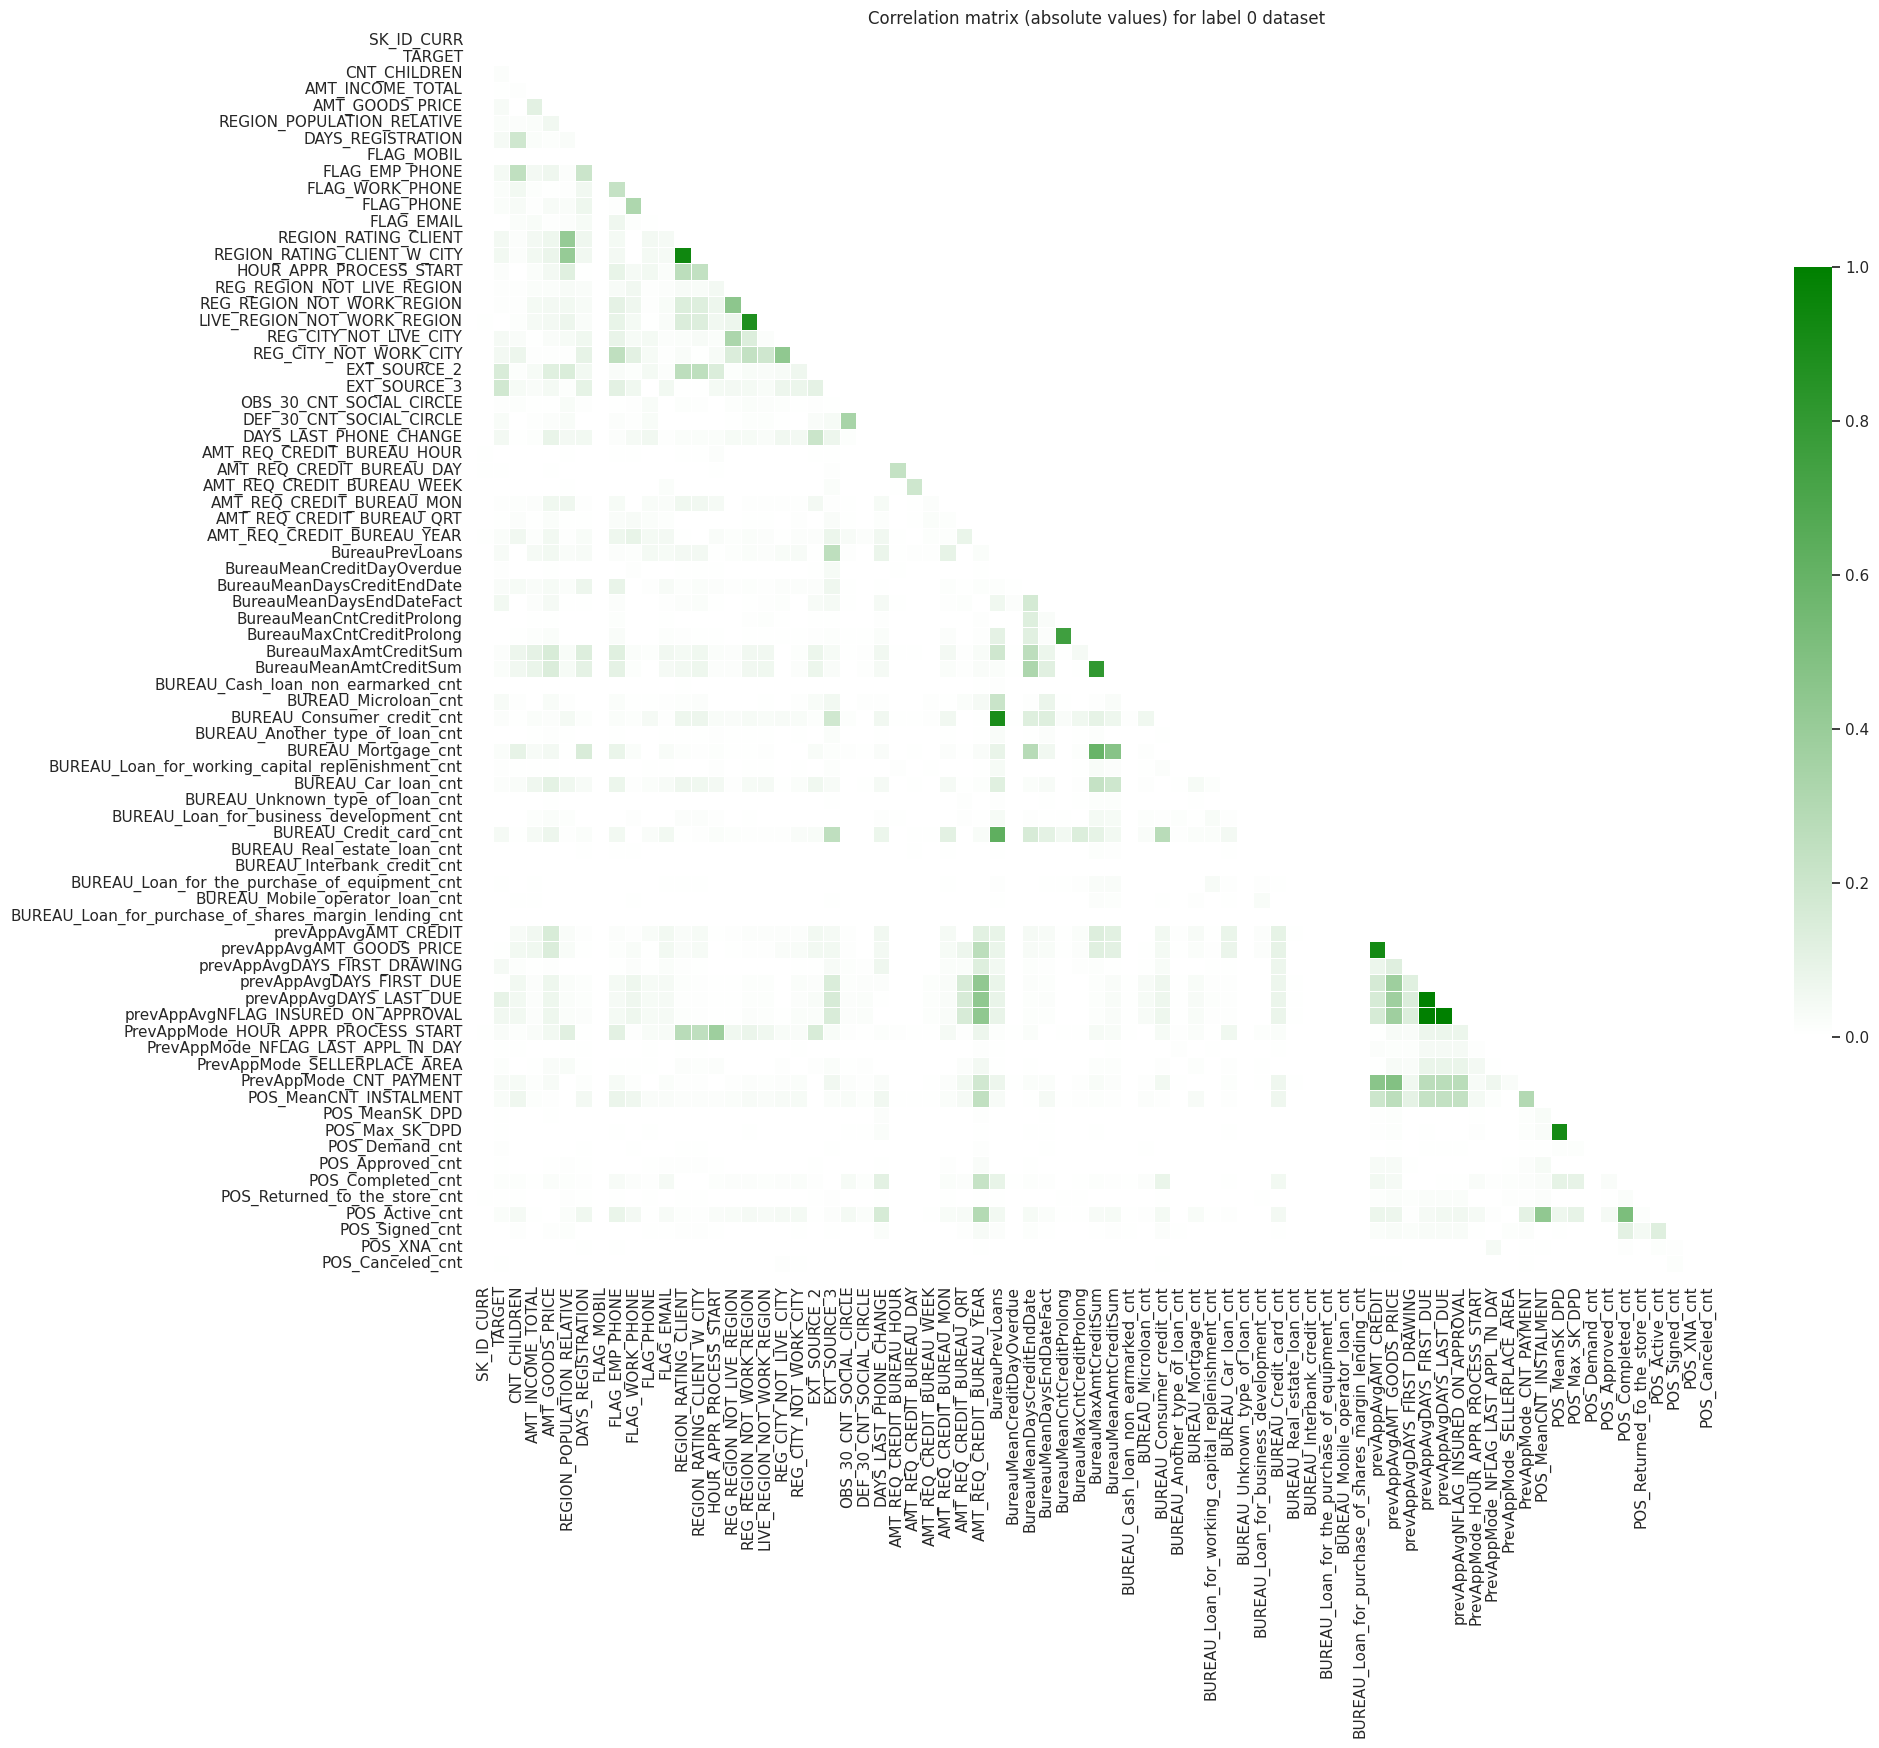

/home/amonroy/ambientes/spark/lib/python3.11/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/home/amonroy/ambientes/spark/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable DAYS_ID_PUBLISH is large: 6094. Are you sure this is not an interval variable? Analysis for pairs of variables including DAYS_ID_PUBLISH can be slow.
  warnings.warn(


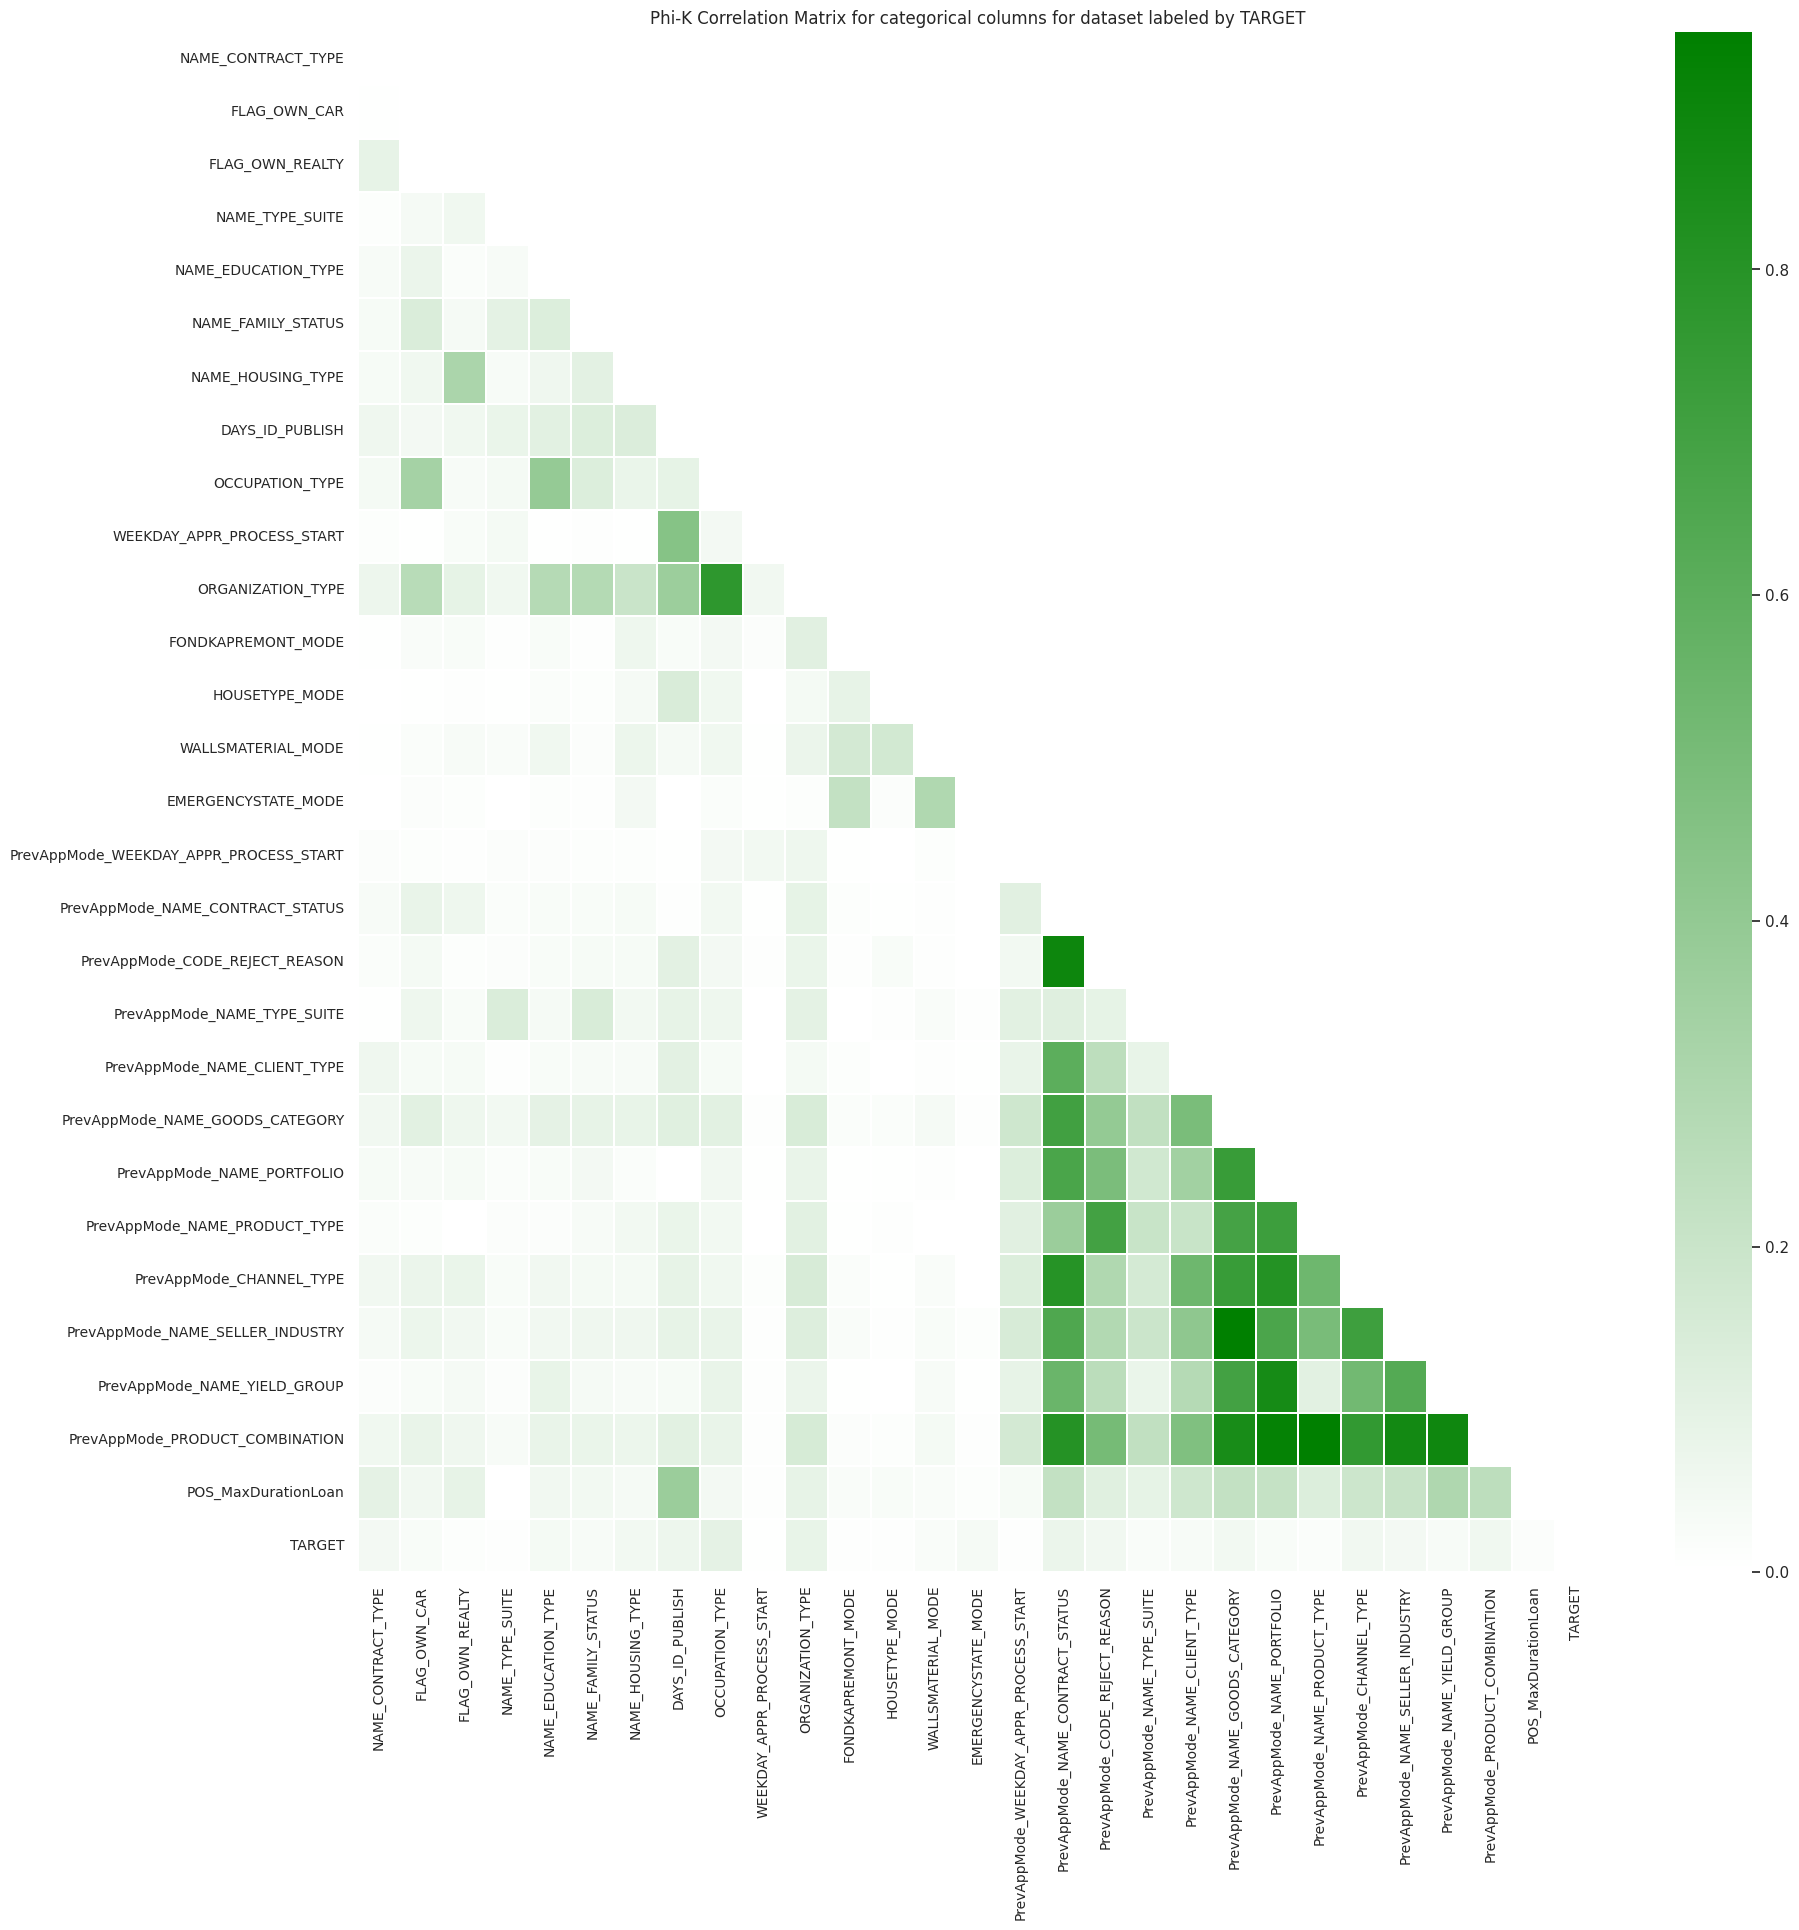

In [2]:
# Correlations labeled 0 data
print('correlation all data')
correlatedCols=edaTools.plot_correlations(dataframe, 'TARGET', ['SK_ID_CURR'], label=0, color="green")

In [3]:
# Drop irrelevant columns (in this final analysis, the created columns were considerated)
correlatedColumns = set(correlatedCols['Pearson']).union(set(correlatedCols['PhiK']))
dataframe = dataframe.drop(*correlatedColumns)

### Train Test Split

In [4]:
# Filtering data by label
dataframe0 = dataframe.filter(dataframe['TARGET']==0)
dataframe1 = dataframe.filter(dataframe['TARGET']==1)

# Split the data in train and test parts (60-40)
trainDf0, testDf0 = dataframe0.randomSplit(weights=[0.6,0.4])
trainDf1, testDf1 = dataframe1.randomSplit(weights=[0.6,0.4])

# Merge the dataframes 
trainDataframe = trainDf0.union(trainDf1)
testDataframe = testDf0.union(testDf1)

# Dellate dataframes that won't be used 
for df in trainDf0,trainDf1,testDf0,testDf1:
    edaTools.borrar(df)

# Obtaining the categorical and numerical cols
ej = [field.name for field in dataframe0.schema.fields]
categoricalCols = []
continuousCols = []
for field in dataframe0.schema.fields:
    if isinstance(field.dataType, (FloatType, IntegerType)):
        continuousCols.append(field.name)
    else:
        categoricalCols.append(field.name)

# Delate the SK_ID_CURR columns for both dataframes
trainDataframe=trainDataframe.drop('SK_ID_CURR')
testDataframe=testDataframe.drop('SK_ID_CURR')

# Show the proportions for each dataframes
trainDataframe.filter(trainDataframe['TARGET']==0).count()/trainDataframe.filter(trainDataframe['TARGET']==1).count(),testDataframe.filter(trainDataframe['TARGET']==0).count()/testDataframe.filter(trainDataframe['TARGET']==1).count()

# Conver data to Pandas (for XGBOOST with categorical data)
train_pd = trainDataframe.toPandas()
test_pd = testDataframe.toPandas()

# Select the feature and target data 
y_train = train_pd[['TARGET']]
X_train = train_pd[[col for col in train_pd.columns if col != 'TARGET']]
y_test = test_pd[['TARGET']]
X_test = test_pd[[col for col in train_pd.columns if col != 'TARGET']]

In [5]:
# Set categorical columns
for catCol in categoricalCols:
    X_train[catCol] = X_train[catCol].astype('category')
    X_test[catCol]=X_test[catCol].astype('category')

/tmp/ipykernel_413082/2692599666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[catCol] = X_train[catCol].astype('category')
/tmp/ipykernel_413082/2692599666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[catCol]=X_test[catCol].astype('category')
/tmp/ipykernel_413082/2692599666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

# MODEL 1: XGBOOST

***JUSTIFICATION:***

After the EDA and the feature engineer the justification of the use of XGBoost is based on:

1. **Tabular Data Format**: XGBoost is well-suited for tabular data, especially when dealing with a large number of features (over 100 columns). It can efficiently handle high-dimensional datasets and extract patterns from such data structures.

2. **Complex Relationships**: XGBoost excels in capturing complex relationships between features and the target variable. It can model non-linear relationships effectively, which is crucial when dealing with datasets where simple linear models may not suffice.

3. **Feature Interactions**: It automatically learns and leverages feature interactions, which is beneficial when dealing with datasets containing features with potentially complex interactions that impact the target variable.

4. **Handling Imbalanced Data**: XGBoost includes mechanisms like weighted samples and regularization techniques that can mitigate the challenges posed by imbalanced datasets, where one class dominates the other (such as your dataset where one class constitutes nearly 90% of the data). This helps in improving the model's ability to predict the minority class accurately.


In the following, two versions of this model are implemented, allowing for the existence of categorical columns, using Optuna to optimize the model's hyperparameter search via the auc. The versions differ in the XGBoost library method used: one utilizes **xgb.train** to train the model, while the other employs the xgboost interface in scikit-learn with **xgb.XGBClassifier**. In both approaches a cross validation is used to achieving a goog generalization with 




***ABOUT THE HYPERPARAMETER OPTIMIZATION***


Given the unbalanced dataset, the assumption of correctly classifying the most common data (clients without payment difficulties) and therefore achieving high accuracy and high precision is reasonably correct. However, ***for business interest, it is crucial to make correct classifications for clients with payment difficulties*** (i.e., the most uncommon data). Therefore, hyperparameter optimization was focused on the AUC for the ROC curve due to its definition and interpretation in terms of the true positive rate (TPR) and the false positive rate (FPR). This means interpreting it as sensitivity or recall as a function of the false positive rate.

Accuracy  was not used because it focuses on the “general classifier,” which often results in high precision but does not address false positives and false negatives. Furthermore, recall was not used because its calculation requires selecting a probability threshold to make predictions. This is how the AUC was used for the ROC curve, considering Cross Validation in generalization views

### VERSION 1: XGBOOST WITH  BAYESIAN OPTIMIZATION FOR HYPERPARAMETERS (using xgb.train)

#### Optuna objective configuration for XGBoost

In [6]:
# Define DMatrix for training and validation data
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dvalid = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Number of splits for the CV
n_splits = 5

# optuna objective function
def objective(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.
    Args:
     trial: Optuna's trial object used to sample hyperparameters.
    Returns:
     AUC (float): The Area Under Curve for the ROC Curve.
    """
    # Define the search space for hyperparameters
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
    }

    # Initialize lists to store AUC values for each fold
    auc_values = []
    
    # Perform cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, valid_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        dtrain_cv = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
        dvalid_cv = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
        
        # Train the model with current hyperparameters
        model = xgb.train(param, dtrain_cv, evals=[(dvalid_cv, 'eval')], verbose_eval=False)
        
        # Predict probabilities for validation set
        probs_pred = model.predict(dvalid_cv)
        
        # Compute AUC for the ROC curve
        auc_value = roc_auc_score(y_val, probs_pred)
        auc_values.append(auc_value)
    
    # Calculate average AUC across all folds
    avg_auc = np.mean(auc_values)
    
    return avg_auc

####  Hyperparameter optimization with optuna

In [7]:
# Creation Optuna Studio
study1 = optuna.create_study(direction='maximize')

# Opimization
print('Optimization:')
study1.optimize(objective, n_trials=100)
print('*'*100, '\nFINISHED' )

# Get the best hyperparameters
best_params1 = study1.best_params

[I 2024-07-10 00:48:48,695] A new study created in memory with name: no-name-dbd7b74c-8d31-44ff-bd56-4ac563ecf4a0


Optimization:


[I 2024-07-10 00:48:49,504] Trial 0 finished with value: 0.9512808606128139 and parameters: {'lambda': 4.270053173809879e-06, 'alpha': 4.40951098010814e-06, 'colsample_bytree': 0.7836612291773419, 'subsample': 0.6668278330559491, 'learning_rate': 0.00017392267677140036, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 5.738187908919106e-06}. Best is trial 0 with value: 0.9512808606128139.
[I 2024-07-10 00:48:50,250] Trial 1 finished with value: 0.9615901429422961 and parameters: {'lambda': 7.157966868007079e-08, 'alpha': 7.379453490066641e-07, 'colsample_bytree': 0.6951808844214075, 'subsample': 0.4140633603092514, 'learning_rate': 1.52637341555435e-05, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 1.5229893583675158e-05}. Best is trial 1 with value: 0.9615901429422961.
[I 2024-07-10 00:48:51,096] Trial 2 finished with value: 0.9891537873931913 and parameters: {'lambda': 3.6445470635104575e-07, 'alpha': 1.4849561303207144e-08, 'colsample_bytree': 0.7268519741290489, 'subsample': 0.969

**************************************************************************************************** 
FINISHED


#### Model trainiing

In [8]:
xgbModel1 = xgb.train(best_params1, dtrain, evals=[(dvalid, 'eval')], verbose_eval=True)

[0]	eval-rmse:0.21246
[1]	eval-rmse:0.18193
[2]	eval-rmse:0.14832
[3]	eval-rmse:0.12886
[4]	eval-rmse:0.11931
[5]	eval-rmse:0.11835
[6]	eval-rmse:0.11347
[7]	eval-rmse:0.11419
[8]	eval-rmse:0.11430
[9]	eval-rmse:0.11485


#### Plots of optimization results

In [9]:
optuna.visualization.plot_parallel_coordinate(study1)

In [10]:
optuna.visualization.plot_optimization_history(study1)

In [11]:
optuna.visualization.plot_param_importances(study1)

#### Model trainning

In [12]:
# Training the model with the best parameters (using as a threshold 
xgbModel1 = xgb.train(study1.best_params, dtrain, evals=[(dvalid, 'eval')])

[0]	eval-rmse:0.21246
[1]	eval-rmse:0.18193
[2]	eval-rmse:0.14832
[3]	eval-rmse:0.12886
[4]	eval-rmse:0.11931
[5]	eval-rmse:0.11835
[6]	eval-rmse:0.11347
[7]	eval-rmse:0.11419
[8]	eval-rmse:0.11430
[9]	eval-rmse:0.11485


#### Model evaluation with the ROC curve and AUC

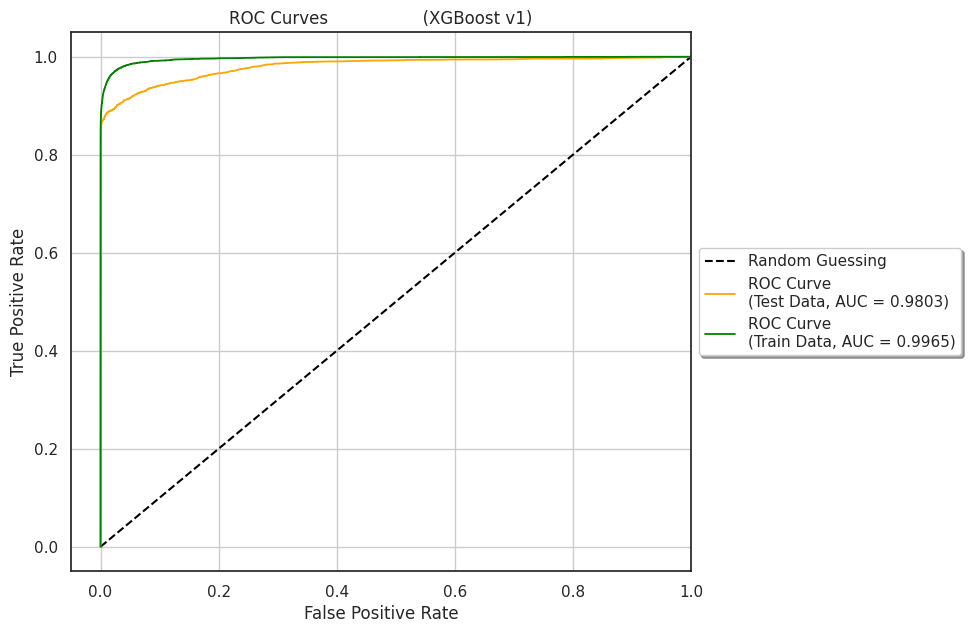

In [13]:
# Initialization for the figure (ROC)
plt.figure(figsize=(8, 7))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--', label='Random Guessing')

# Compute the ROC curve and the AUC using probabilities for the test data
probs_pred_train1 = xgbModel1.predict(dtrain)
fpr_train, tpr_train, _ = roc_curve(y_train, probs_pred_train1)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute the ROC curve and the AUC for the training data
probs_pred_test1 = xgbModel1.predict(dvalid)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_pred_test1)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.plot(fpr_test, tpr_test, lw=1.3, ls='-', label=f'ROC Curve \n(Test Data, AUC = {round(roc_auc_test,4)})', color='orange')
plt.plot(fpr_train, tpr_train, lw=1.3, ls='-', label=f'ROC Curve \n(Train Data, AUC = {round(roc_auc_train,4)})', color='green')

# Plot Configuration
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves                  (XGBoost v1)')
plt.grid(True)

# Legends
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()

#### Analysis based on recall, precicions and F1 score

In [14]:
# REALL, PRECICION AND F1 SCORES VALUES IN FUNCTION OF THE THRESHOLD

# Initialize lists to store the values of recall, precision, F1 score, and AUC-ROC
recalls = []
precisions = []
f1_scores = []

# Compute predictions
preds = xgbModel1.predict(dvalid)

# Iterate over different thresholds
thresholds = np.linspace(0.01, 0.99, 100)
for threshold in thresholds:

    # Compute predictions for the test data
    pred_labels = [1 if pred > threshold else 0 for pred in preds]
    
    # Compute the metrics
    recall = recall_score(y_test, pred_labels)
    precision = precision_score(y_test, pred_labels)
    f1 = f1_score(y_test, pred_labels)
    
    # Store the values in the lists
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

<Figure size 800x600 with 0 Axes>

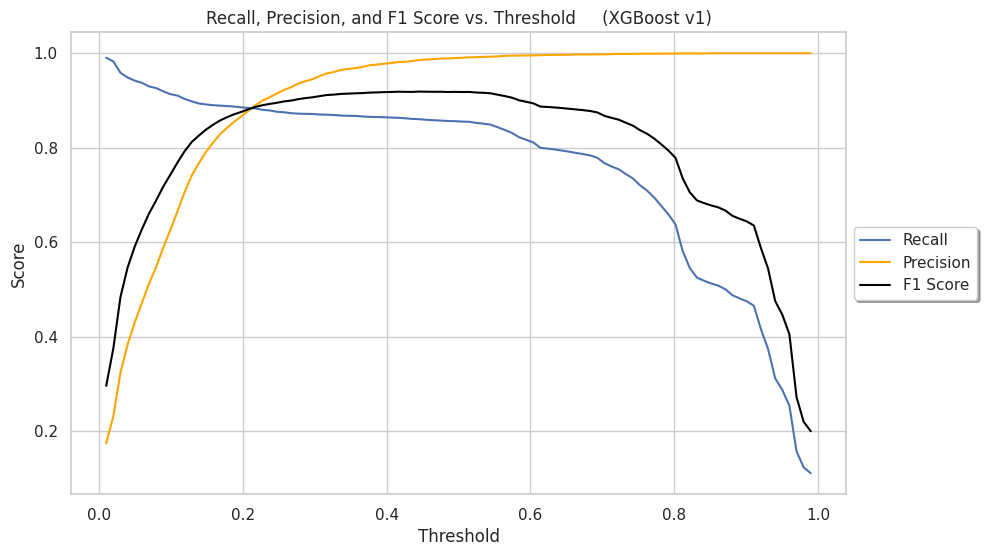

In [15]:
# SEABORN PLOT FOR RECALL, PRECISION AND F1 SCORE VS THRESHOLD 

# Initialize the figure for ROC curves
plt.figure(figsize=(8, 6))
# Set Seaborn style for the metrics vs. threshold plot
sns.set(style="whitegrid")

# Plot the values of recall, precision, F1 score, and AUC-ROC as a function of the threshold
plt.figure(figsize=(10, 6))

sns.lineplot(x=thresholds, y=recalls, marker='', label='Recall')
sns.lineplot(x=thresholds, y=precisions, marker='', label='Precision', color='orange')
sns.lineplot(x=thresholds, y=f1_scores, marker='', label='F1 Score', color='black')

plt.title('Recall, Precision, and F1 Score vs. Threshold     (XGBoost v1)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [16]:
#PLOTLY INTERACTIVE PLOT FOR THE RECALL, PRECISION AND F1 SCORE VS THRESHOLD 

# Pandas dataframe creation for simplicity
data_treshold = {'Threshold': thresholds,
    'Recall': recalls,
    'Precision': precisions,
    'F1 Score': f1_scores}
data_treshold_DF = pd.DataFrame(data_treshold)

# create plotly figure
fig = go.Figure()

# Add lines for each metric
fig.add_trace(go.Scatter(x=data_treshold_DF['Threshold'], y=data_treshold_DF['Recall'], mode='lines', name='Recall'))
fig.add_trace(go.Scatter(x=data_treshold_DF['Threshold'], y=data_treshold_DF['Precision'], mode='lines', name='Precision', marker=dict(color='orange')))
fig.add_trace(go.Scatter(x=data_treshold_DF['Threshold'], y=data_treshold_DF['F1 Score'], mode='lines', name='F1 Score', marker=dict(color='black')))

# LAyout configurations
fig.update_layout(
    title='                    Recall, Precision and F1 Score  vs Threshold               (XGBoost v1)',
    xaxis_title='Threshold',
    yaxis_title='Score',
    legend=dict(x=1.05, y=1),
    margin=dict(l=0, r=0, t=30, b=0)
)

# Show plot
fig.show()

### VERSION 2: XGBOOST WITH HYPERPARAMETER TUNNING  (using xgb.XGBClassifier)

#### Optuna  objective configuration for XGBoost

In [17]:
# Optuna objective function
def objective(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.
    Args:
     trial: Optuna's trial object used to sample hyperparameters.
    Returns:
     AUC (float): The Area Under Curve for the ROC Curve.
    """
    # Define the search space for hyperparameters
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'n_estimators': 100  # Set a fixed number of trees, adjust as necessary
    }

    # Perform cross-validation with 5 folds
    model = xgb.XGBClassifier(**param, enable_categorical=True)
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    # Calculate mean AUC from cross-validation
    auc_mean = np.mean(auc_scores)

    return auc_mean

####  Hyperparameter optimization with optuna

In [18]:
# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-07-10 00:50:56,410] A new study created in memory with name: no-name-6503cf07-a099-4e97-ad33-ef4de6a5258c
[I 2024-07-10 00:51:00,433] Trial 0 finished with value: 0.9858079467222909 and parameters: {'lambda': 1.7706558331907932e-07, 'alpha': 0.1573178528258188, 'colsample_bytree': 0.6252012312942843, 'subsample': 0.6042443158940082, 'learning_rate': 0.40021209936717644, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 1.6580306151583253e-07}. Best is trial 0 with value: 0.9858079467222909.
[I 2024-07-10 00:51:03,055] Trial 1 finished with value: 0.9825082959086606 and parameters: {'lambda': 0.0005169493325158207, 'alpha': 0.8946798927531234, 'colsample_bytree': 0.6271017319914401, 'subsample': 0.6552289829664375, 'learning_rate': 0.0037118573940407833, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.01786348360214814}. Best is trial 0 with value: 0.9858079467222909.
[I 2024-07-10 00:51:07,369] Trial 2 finished with value: 0.9884074388827928 and parameters: {'lambda': 0.9474197

In [19]:
best_params = study.best_params

# Entrenar el modelo final con los mejores hiperparámetros
xgbModel2 = xgb.XGBClassifier(**best_params, enable_categorical=True)
xgbModel2.fit(X_train, y_train)

XGBClassifier(alpha=0.00022873713838075498, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5356443202635062, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.02021446994634122,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=3.488925436646435e-06,
              learning_rate=0.0556112507505641, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

#### Plots of optimization results

In [20]:
optuna.visualization.plot_parallel_coordinate(study)

In [21]:
optuna.visualization.plot_optimization_history(study)

In [22]:
optuna.visualization.plot_param_importances(study)

#### ROC curves

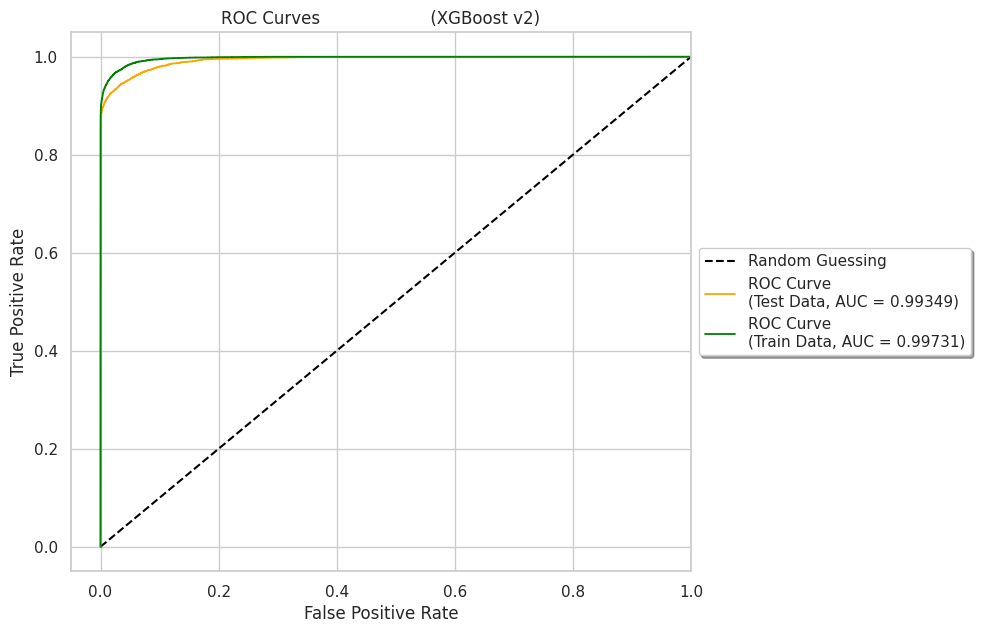

In [23]:
# Initialization for the figure (ROC)
plt.figure(figsize=(8, 7))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle='--', label='Random Guessing')

# Compute predictions using the final_model
probs_pred_train = xgbModel2.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, probs_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

probs_pred_test = xgbModel2.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, probs_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)


# Plot ROC curves
plt.plot(fpr_test, tpr_test, lw=1.3, ls='-', label=f'ROC Curve \n(Test Data, AUC = {round(roc_auc_test,5)})', color='orange')
plt.plot(fpr_train, tpr_train, lw=1.3, ls='-', label=f'ROC Curve \n(Train Data, AUC = {round(roc_auc_train,5)})', color='green')

# Plot Configuration
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves                     (XGBoost v2)')
plt.grid(True)

# Legends
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()


#### Recall, Precision and F1-Score analysis in function of the threshold

In [24]:
# Compute probabilities for the test data
probs_pred_test_2 = xgbModel2.predict_proba(X_test)[:, 1]

#################### RECALL, PRECISION AND F1-SCORES #######################
# RECALL, PRECISION AND F1 SCORES VALUES IN FUNCTION OF THE THRESHOLD

# Initialize lists to store the values of recall, precision, F1 score, and AUC-ROC
recalls2 = []
precisions2 = []
f1_scores2 = []
roc_aucs2 = []

# Iterate over different thresholds
thresholds = np.linspace(0.01, 0.99, 100)
for threshold in thresholds:
    # Compute predictions for the test data
    pred_labels2 = [1 if pred > threshold else 0 for pred in probs_pred_test_2]
    
    # Compute the metrics
    recall2 = recall_score(y_test, pred_labels2)
    precision2 = precision_score(y_test, pred_labels2)
    f1_2 = f1_score(y_test, pred_labels2)
    
    # Store the values in the lists
    recalls2.append(recall2)
    precisions2.append(precision2)
    f1_scores2.append(f1_2)

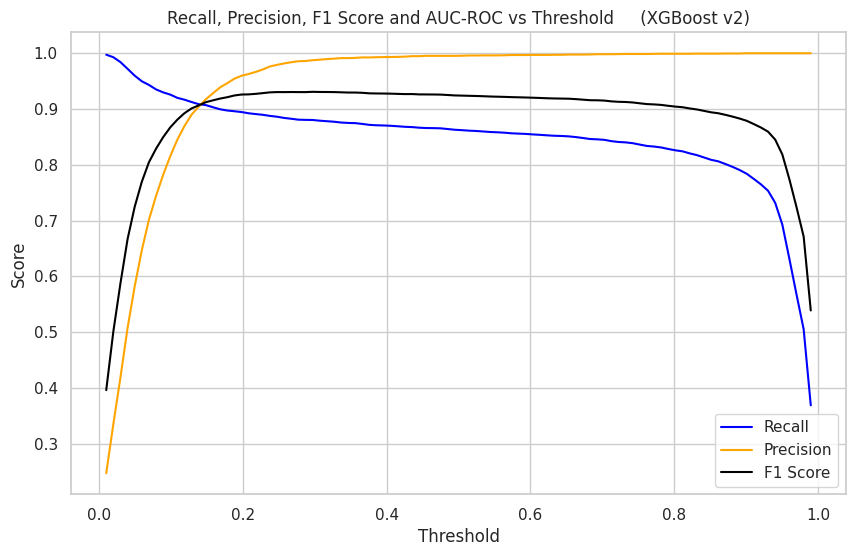

In [25]:
# Set Seaborn style
sns.set(style="whitegrid")

# Plot the values of recall, precision, F1 score, and AUC-ROC as a function of the threshold
plt.figure(figsize=(10, 6))

sns.lineplot(x=thresholds, y=recalls2, marker='', label='Recall', color='blue')
sns.lineplot(x=thresholds, y=precisions2, marker='', label='Precision', color='orange')
sns.lineplot(x=thresholds, y=f1_scores2, marker='', label='F1 Score', color='black')

plt.title('Recall, Precision, F1 Score and AUC-ROC vs Threshold     (XGBoost v2)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
#################### RECALL, PRECISION AND F1-SCORES #######################
# Pandas dataframe creation for simplicity
data_treshold2 = {
    'Threshold': thresholds,
    'Recall': recalls2,
    'Precision': precisions2,
    'F1 Score': f1_scores2,
}
data_treshold_DF2 = pd.DataFrame(data_treshold2)

# Create plotly figure
fig2 = go.Figure()

# Add lines for each metric
fig2.add_trace(go.Scatter(x=data_treshold_DF2['Threshold'], y=data_treshold_DF2['Recall'], mode='lines', name='Recall'))
fig2.add_trace(go.Scatter(x=data_treshold_DF2['Threshold'], y=data_treshold_DF2['Precision'], mode='lines', name='Precision', marker=dict(color='orange')))
fig2.add_trace(go.Scatter(x=data_treshold_DF2['Threshold'], y=data_treshold_DF2['F1 Score'], mode='lines', name='F1 Score', marker=dict(color='black')))

# Layout configurations
fig2.update_layout(
    title='Recall, Precision, F1 Score and AUC-ROC vs Threshold    (XGBoost v2)',
    xaxis_title='Threshold',
    yaxis_title='Score',
    legend=dict(x=1.05, y=1),
    margin=dict(l=0, r=0, t=30, b=0)
)

# Show plot
fig2.show()

### Selection of the  best model:

Based on the     AUC of the ROC curve and the recall, precision, F1-Score vs thresholds plots the best model is the one that uses the XGBClassifier and the interface of scitkitlearn.

The two graphs above analyze the relationship between recall, precision and F1 score versus threshold, where threshold values ​​between 0.15 and 0.9 give an F1 score value in the range of 0.9 to 0, 93; Depending on domain knowledge, a slight increase given in a recall of 0.9 at the cost of a smaller F1 score and precision may consider a better model than the one with the larger F1 score. Then, given the priority of correctly classifying less common data, namely customers with payment difficulties, **a probability threshold of 0.15** is selected. At this threshold, the recall value, precision, and F1 score are approximately 0.9.

A lower threshold implies a better classification of clients with payment difficulties, but it significantly increases the cost of misclassifying clients without payment difficulties. The optimal model should balance the bank's average gains from clients who will not have payment problems and the losses associated with clients who will have difficulties repaying their loans.

By obtaining the total profit balance from this, we can objectively determine the best model. This approach may necessitate considering other external factors in the model to achieve a comprehensive evaluation

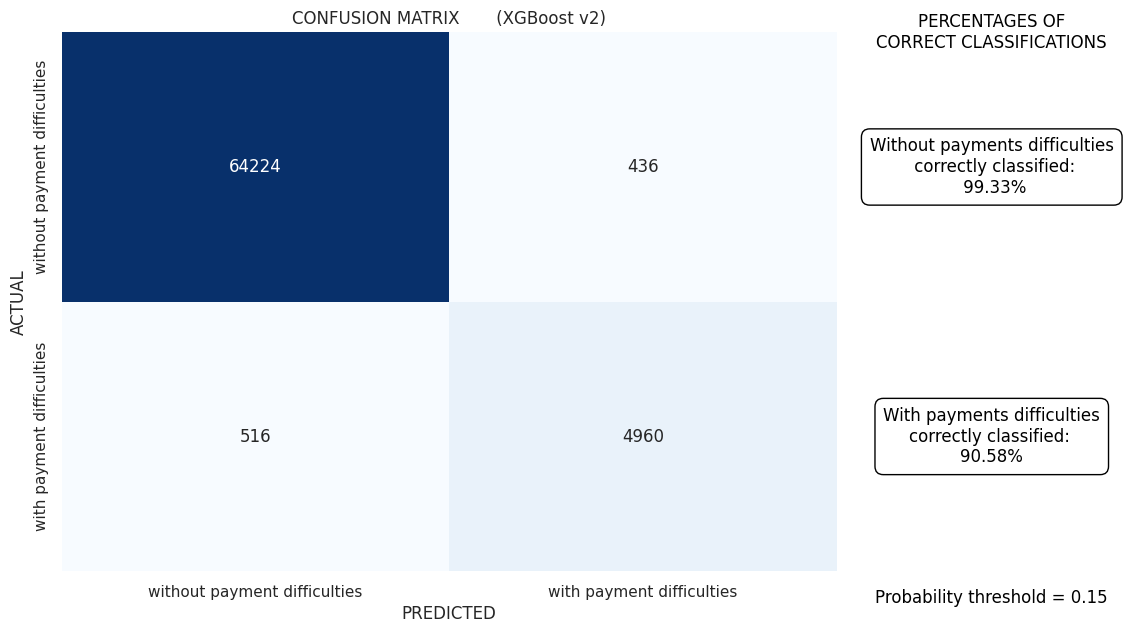

In [27]:
# Obtener las probabilidades de predicción del clasificador
MODEL2_THRESHOLD = 0.15

# Obtener las etiquetas predichas basadas en el umbral
pred_labels2 = [1 if pred > MODEL2_THRESHOLD else 0 for pred in probs_pred_test_2]


# Calcular la matriz de confusión
cm = confusion_matrix(y_test, pred_labels2)

# Crear un DataFrame a partir de la matriz de confusión para una mejor visualización con Seaborn
cm_df = pd.DataFrame(cm, index=['without payment difficulties', 'with payment difficulties'],
                     columns=['without payment difficulties', 'with payment difficulties'])

# Calcular los porcentajes para una interpretación más fácil
percentage_with_difficulties_correctly_classified = (cm[1, 1] / (cm[1, 0] + cm[1, 1])) * 100
percentage_without_difficulties_correctly_classified = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) * 100

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('CONFUSION MATRIX       (XGBoost v2)')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

# Añadir leyendas con porcentajes
plt.text(2.4, 0, "PERCENTAGES OF\nCORRECT CLASSIFICATIONS", 
         fontsize=12, color='black', ha='center', va='center')
plt.text(2.4, 0.5, f'Without payments difficulties\n correctly classified:\n {percentage_without_difficulties_correctly_classified:.2f}%', 
         fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(2.4, 1.5, f'With payments difficulties\ncorrectly classified: \n{percentage_with_difficulties_correctly_classified:.2f}%', 
         fontsize=12, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(2.4, 2.1, f"Probability threshold = {round(MODEL2_THRESHOLD, 3)}", 
         fontsize=12, color='black', ha='center', va='center')
plt.show()


#### Saving model as a json file

In [28]:
import json

# Save the trained model as a JSON file
model_filename = 'xgb_final_model.json'
xgbModel2.save_model(model_filename)


# Save the threshold to a JSON file
threshold_data = {'threshold': MODEL2_THRESHOLD}
threshold_filename = 'threshold.json'
with open(threshold_filename, 'w') as f:
    json.dump(threshold_data, f)

#### Load model

In [29]:
# Load the model from the JSON file
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('xgb_final_model.json')

# Load the threshold from the JSON file
with open('threshold.json', 'r') as f:
    threshold_data = json.load(f)
    loaded_threshold = threshold_data['threshold']

# Verify loaded threshold
print(f"Loaded threshold: {loaded_threshold}")

Loaded threshold: 0.15


# MODEL 2: Logistic Regression

### Using undersampling with PCA for dimensionality reduction

#### PCA implementation and cumulative explained variance analysis

In [30]:
edaTools.show(dataframe)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100003       0         Cash loans            N               N   
1      100110       0         Cash loans            Y               Y   
2      100220       0         Cash loans            N               Y   
3      100240       0         Cash loans            N               Y   
4      100274       0         Cash loans            Y               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
0             0          270000.0        1129500.0          Family   
1             3          135000.0         337500.0   Unaccompanied   
2             0          225000.0         909000.0   Unaccompanied   
3             2          135000.0         477000.0   Unaccompanied   
4             0          308250.0        1305000.0          Family   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0               Higher education               Married  House / apartment   
1  Secondary / secondary special               Married  House / apartment   
2               Higher education  Single / not married  House / apartment   
3  Secondary / secondary special               Married  House / apartment   
4  Secondary / secondary special        Civil marriage  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_REGISTRATION DAYS_ID_PUBLISH  FLAG_MOBIL  \
0                    0.003541            -1186.0            -291           1   
1                    0.035792             -442.0           -2381           1   
2                    0.003818            -1147.0           -4138           1   
3                    0.018029            -6005.0           -4099           1   
4                    0.026392            -8060.0           -4018           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0               1                0           1           0      Core staff   
1               1                0           0           0        Laborers   
2               1                0           0           0     Sales staff   
3               1                0           1           0        Laborers   
4               1                1           1           0         Drivers   

   REGION_RATING_CLIENT WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                     1                     MONDAY                       11   
1                     2                  WEDNESDAY                        9   
2                     2                    TUESDAY                        6   
3                     3                     SUNDAY                        8   
4                     2                     MONDAY                       14   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0                       0      0.622246      0.520969   
1                       0                       1      0.640549      0.328063   
2                       0                       0      0.626339      0.607557   
3                       0                       0      0.628532      0.121408   
4                       0                       0      0.698453      0.800451   

  FONDKAPREMONT_MODE  HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
0   reg oper account  block of flats              Block                  No   
1               None            None               None                  No   
2   reg oper account  block of flats              Panel                  No   
3   reg oper account  terraced house             Wooden                  No   
4     

In [31]:
from sklearn.model_selection import train_test_split

dataframe_lr = dataframe.drop('SK_ID_CURR')

edaTools.show(dataframe_lr, 1)

TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       0         Cash loans            N               N             0   

   AMT_INCOME_TOTAL  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_EDUCATION_TYPE  \
0          270000.0        1129500.0          Family    Higher education   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.003541   

   DAYS_REGISTRATION DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
0            -1186.0            -291           1               1   

   FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0                0           1           0      Core staff   

   REGION_RATING_CLIENT WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                     1                     MONDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0                       0      0.622246      0.520969   

  FONDKAPREMONT_MODE  HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
0   reg oper account  block of flats              Block                  No   

   OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                       1.0                       0.0                  -828.0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
0                        0.0                         0.0   

   BureauMeanCreditDayOverdue  BureauMeanDaysCreditEndDate  \
0                         0.0                    85.333336   

   BureauMeanDaysEndDateFact  BureauMeanCntCreditProlong  \
0                 -730.47583                         0.0   

   BUREAU_Cash_loan_non_earmarked_cnt  BUREAU_Microloan_cnt  \
0                                   0                     0   

   BUREAU_Another_type_of_loan_cnt  BUREAU_Mortgage_cnt  \
0                                0                    0   

   BUREAU_Loan_for_working_capital_replenishment_cnt  BUREAU_Car_loan_cnt  \
0                                                  0                    0   

   BUREAU_Unknown_type_of_loan_cnt  BUREAU_Loan_for_business_development_cnt  \
0                                0                                         0   

   BUREAU_Credit_card_cnt  BUREAU_Real_estate_loan_cnt  \
0                       2                            0   

   BUREAU_Interbank_credit_cnt  BUREAU_Loan_for_the_purchase_of_equipment_cnt  \
0                            0                                              0   

   BUREAU_Mobile_operator_loan_cnt  \
0                                0   

   BUREAU_Loan_for_purchase_of_shares_margin_lending_cnt  \
0                                                      0   

   prevAppAvgAMT_CREDIT  prevAppAvgDAYS_FIRST_DRAWING  \
0              348637.5                      365243.0   

   prevAppAvgNFLAG_INSURED_ON_APPROVAL PrevAppMode_WEEKDAY_APPR_PROCESS_START  \
0                                  0.0                                 SUNDAY   

   PrevAppMode_HOUR_APPR_PROCESS_START  PrevAppMode_NFLAG_LAST_APPL_IN_DAY  \
0                                   17                                   1   

  PrevAppMode_NAME_TYPE_SUITE PrevAppMode_NAME_CLIENT_TYPE  \
0                      Family                    Refreshed   

  PrevAppMode_NAME_GOODS_CATEGORY PrevAppMode_NAME_PORTFOLIO  \
0                       Furniture                        POS   

  PrevAppMode_NAME_PRODUCT_TYPE PrevAppMode_CHANNEL_TYPE  \
0                           XNA                    Stone   

   PrevAppMode_SELLERPLACE_AREA PrevAppMode_NAME_SELLER_INDUSTRY  \


In [32]:
# Categorical and numerical columns
categoricalCols = [field.name for field  in dataframe.schema.fields if isinstance(field.dataType, StringType)]
categoricalCols = [col for col in categoricalCols if col not in ['DAYS_ID_PUBLISH', 'SK_ID_CURR', 'TARGET','POS_MaxDurationLoan_index', 'POS_MaxDurationLoan']]

# One Hot Encoding for the train and test dataframe
dataframe_lr = pd.get_dummies(dataframe_lr.toPandas(), columns = categoricalCols, dtype = int)

# STrain Test Split
X = dataframe_lr.drop('TARGET', axis=1)  
y = dataframe_lr['TARGET']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

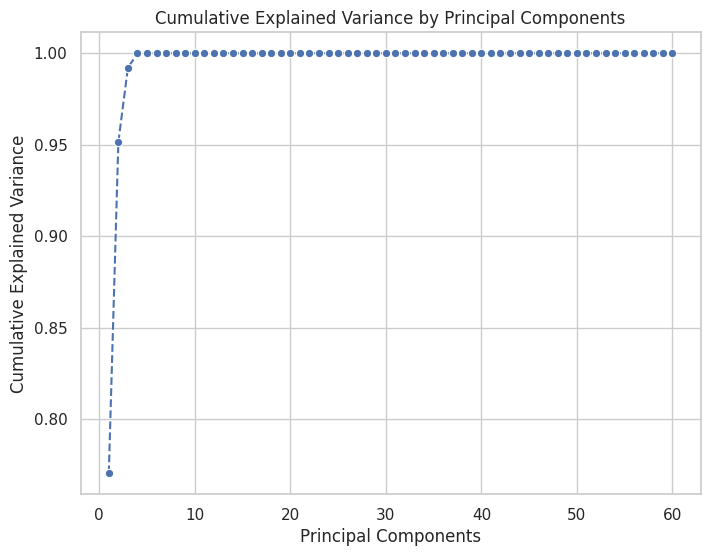

In [33]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of principal components you want to keep
n_components = 60

# Initialize the PCA model with the specified number of components
pca_exploratory = PCA(n_components=n_components)

# Fit the PCA model to the data and transform the data to the new PCA space
# X_train_df is assumed to be your DataFrame of training data
X_train_60PCA = pca_exploratory.fit_transform(X_train)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca_exploratory.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, n_components + 1), y=cumulative_explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()


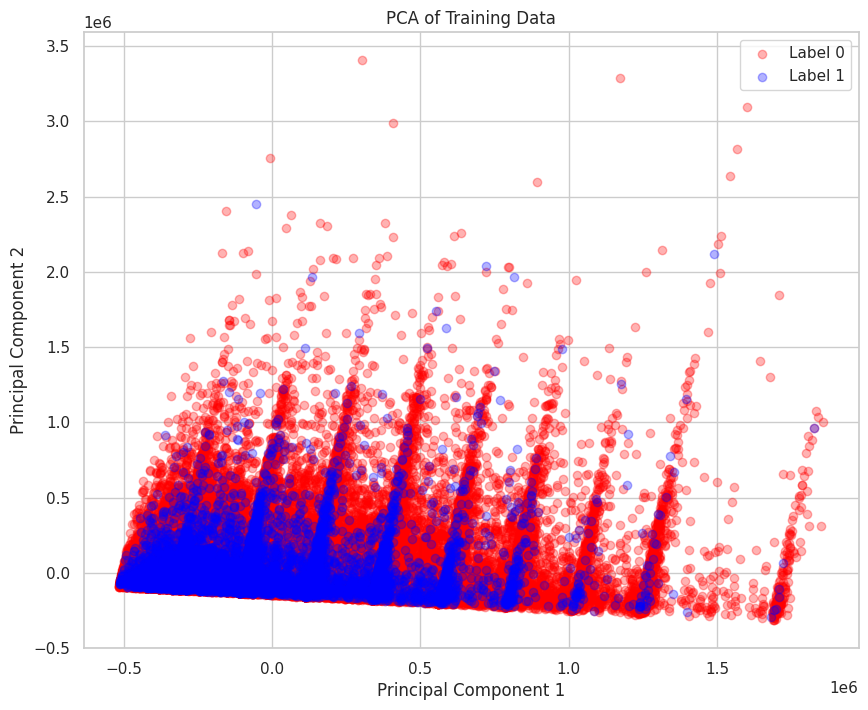

In [41]:
# Initialize the PCA model with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the data and transform the data to the new PCA space
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.fit_transform(X_test)
y_trainNP =   y_train
y_testNP  =  y_test  


# Add the labels as a new column to the PCA-transformed training data
X_train_pca_with_labels = np.column_stack((X_train_pca, y_trainNP))

# Add the labels as a new column to the PCA-transformed test data
X_test_pca_with_labels = np.column_stack((X_test_pca, y_testNP))


# Separate the PCA-transformed data based on labels
X_train_pca_class0 = X_train_pca_with_labels[X_train_pca_with_labels[:, 2] == 0]
X_train_pca_class1 = X_train_pca_with_labels[X_train_pca_with_labels[:, 2] == 1]

# Create the plot
plt.figure(figsize=(10, 8))

# Plot class 0 points in red
plt.scatter(X_train_pca_class0[:, 0], X_train_pca_class0[:, 1], c='red', label='Label 0', alpha=0.3)

# Plot class 1 points in blue
plt.scatter(X_train_pca_class1[:, 0], X_train_pca_class1[:, 1], c='blue', label='Label 1', alpha=0.3)

# Add title and labels
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

/home/amonroy/ambientes/spark/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


25 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/home/amonroy/ambientes/spark/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/amonroy/ambientes/spark/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/amonroy/ambientes/spark/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_paramete

Best hyperparameters found:  {'C': 0.01, 'l1_ratio': 0.8, 'penalty': 'elasticnet', 'solver': 'saga'}


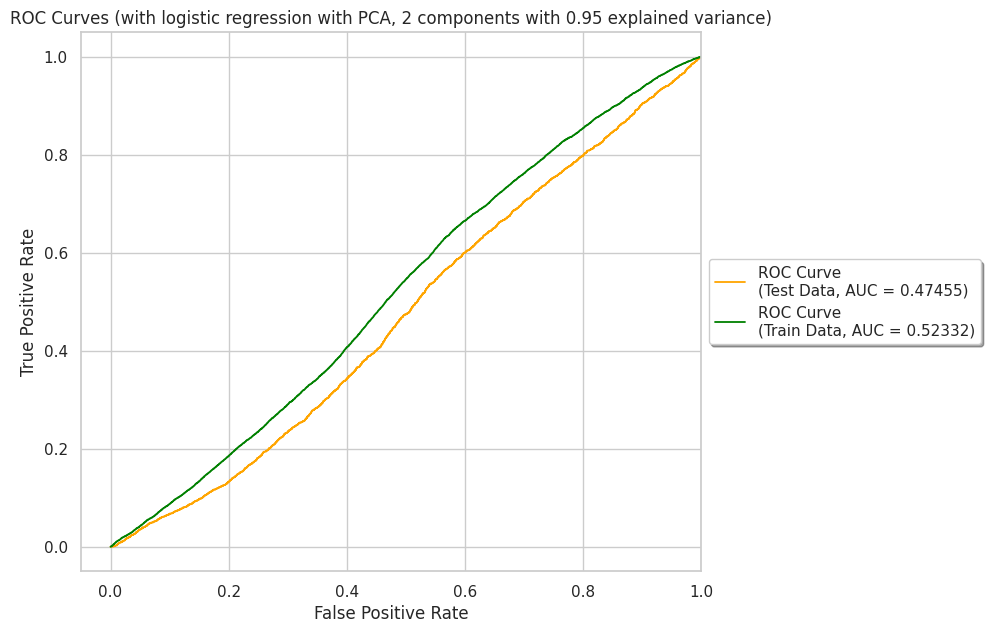

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



# Perform logistic regression with grid search for hyperparameter tuning
logreg = LogisticRegression(max_iter=1000)

# Define the hyperparameters and the values to be searched
param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['saga']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['saga']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': np.arange(0, 1.1, 0.1)},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['none'], 'solver': ['saga']}
]

# Initialize GridSearchCV with logistic regression model and parameter grid
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_pca, y_trainNP)

# Get the best model from grid search
best_logreg = grid_search.best_estimator_

# Print best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Generate ROC curves for training and test data
y_train_prob = best_logreg.predict_proba(X_train_pca)[:, 1]
y_test_prob = best_logreg.predict_proba(X_test_pca)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_trainNP, y_train_prob)
roc_auc_train = roc_auc_score(y_trainNP, y_train_prob)

fpr_test, tpr_test, _ = roc_curve(y_testNP, y_test_prob)
roc_auc_test = roc_auc_score(y_testNP, y_test_prob)




plt.figure(figsize=(8, 7))

# Plot ROC curves
plt.plot(fpr_test, tpr_test, lw=1.3, ls='-', label=f'ROC Curve \n(Test Data, AUC = {round(roc_auc_test, 5)})', color='orange')
plt.plot(fpr_train, tpr_train, lw=1.3, ls='-', label=f'ROC Curve \n(Train Data, AUC = {round(roc_auc_train, 5)})', color='green')

# Plot Configuration
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (with logistic regression with PCA, 2 components with 0.95 explained variance)')
plt.grid(True)

# Legends
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()

### Using Undersampling without PCA

In these case, given the high dimensionality of the data the training will be made by pyspark using its tools for hyperparameter search

In [36]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import Row
import numpy as np


# Get train and test values (as numpy arrays)
trainData = np.column_stack((X_train, y_train))
testData = np.column_stack((X_test, y_test))


# Finction to convert numpy arrays to PySpark DataFrames
def to_spark_df(data):
    rows = [Row(features=Vectors.dense(row[:-1]), label=row[-1]) for row in data]
    return spark.createDataFrame(rows)

train_df_pyspark = to_spark_df(trainData).repartition(20) # To avoid size warnings
test_df_pyspark = to_spark_df(testData)

# Take a sample of the data 
train_df_pyspark = train_df_pyspark.sample(0.5)
test_df_pyspark  = test_df_pyspark.sample(0.5)


# Define the VectorAssembler and StandardScaler
assembler = VectorAssembler(inputCols=["features"], outputCol="assembled_features")
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# Define the logistic regression model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label")

# Create the pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Configure the hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")

# CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Train the model
cvModel = crossval.fit(train_df_pyspark)

24/07/10 00:58:29 WARN TaskSetManager: Stage 129 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:58:33 WARN TaskSetManager: Stage 244 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:58:44 WARN TaskSetManager: Stage 864 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:58:47 WARN TaskSetManager: Stage 976 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:58:57 WARN TaskSetManager: Stage 1608 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:58:59 WARN TaskSetManager: Stage 1726 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:59:07 WARN TaskSetManager: Stage 2355 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 K

In [37]:
best_model = cvModel.bestModel
best_lr_model = best_model.stages[2]

#### ROC Curves

24/07/10 00:59:31 WARN TaskSetManager: Stage 3937 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:59:32 WARN TaskSetManager: Stage 3940 contains a task of very large size (8240 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:59:33 WARN TaskSetManager: Stage 3943 contains a task of very large size (2065 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:59:33 WARN TaskSetManager: Stage 3944 contains a task of very large size (2065 KiB). The maximum recommended task size is 1000 KiB.


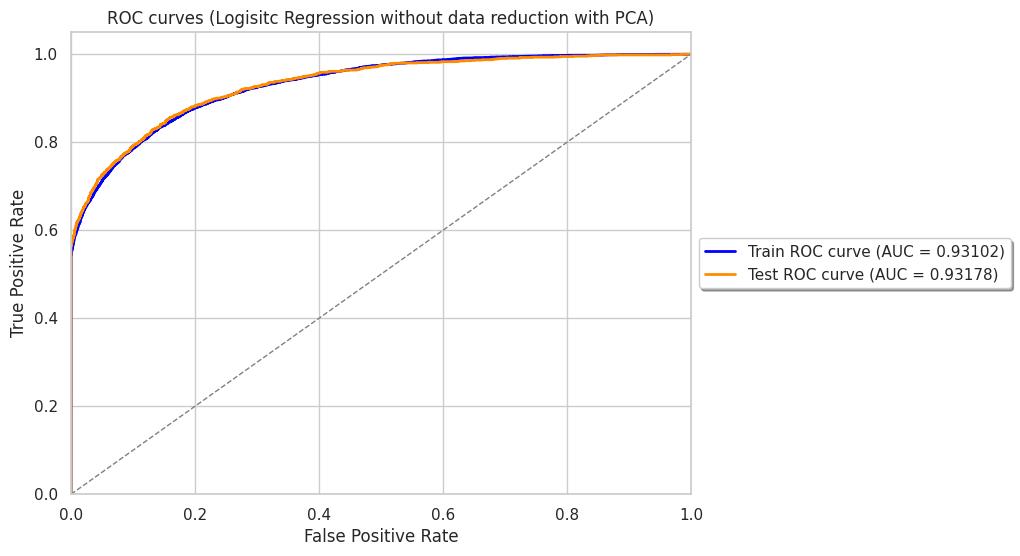

In [38]:
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on training data
train_predictions = best_model.transform(train_df_pyspark)
train_scores = train_predictions.select("label", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["label"]))).collect()

# Predict on test data
test_predictions = best_model.transform(test_df_pyspark)
test_scores = test_predictions.select("label", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["label"]))).collect()

# Extract scores and labels for ROC curve
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

train_fpr, train_tpr, _ = roc_curve(train_scores[:, 1], train_scores[:, 0])
test_fpr, test_tpr, _ = roc_curve(test_scores[:, 1], test_scores[:, 0])

train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

# Plot ROC curve



plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC curve (AUC = {train_auc:.5f})')
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'Test ROC curve (AUC = {test_auc:.5f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves (Logisitc Regression without data reduction with PCA)')
# Legends
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()


#### Recall, Precision and F1-Score analysis in function of the threshold

24/07/10 00:59:34 WARN TaskSetManager: Stage 3945 contains a task of very large size (2065 KiB). The maximum recommended task size is 1000 KiB.
24/07/10 00:59:34 WARN TaskSetManager: Stage 3946 contains a task of very large size (2065 KiB). The maximum recommended task size is 1000 KiB.


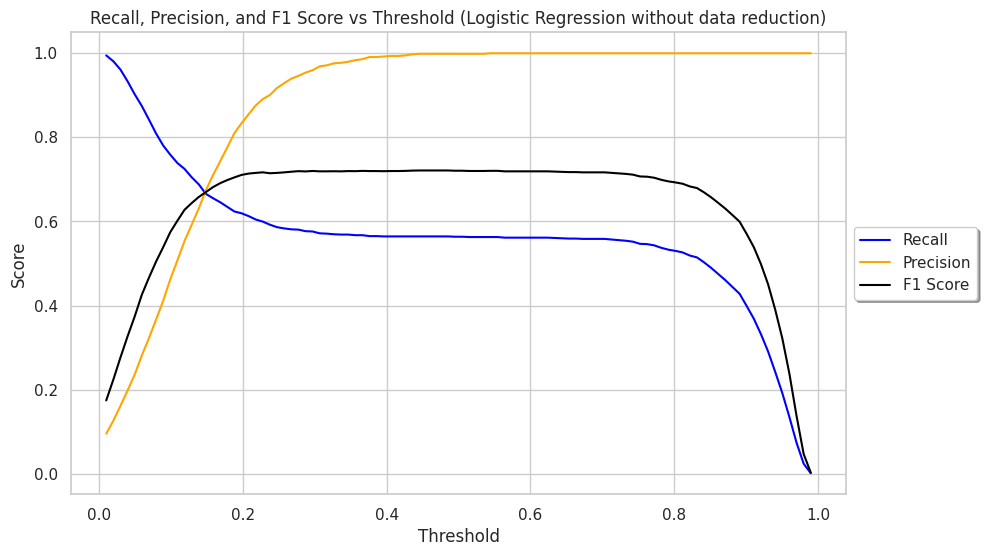

In [39]:
# Predict on test data
test_predictions = best_model.transform(test_df_pyspark)
test_scores = test_predictions.select("label", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["label"]))).collect()

# Extract scores and labels
test_scores = np.array(test_scores)
probabilities = test_scores[:, 0]
labels = test_scores[:, 1]

# Compute precision, recall and F1-score values in function of the threshold
recalls = []
precisions = []
f1_scores = []

# Iterate over different thresholds
thresholds = np.linspace(0.01, 0.99, 100)
for threshold in thresholds:
    # Compute predictions for the test data based on the threshold
    pred_labels = [1 if prob > threshold else 0 for prob in probabilities]
    
    # Compute the metrics
    recall = recall_score(labels, pred_labels)
    precision = precision_score(labels, pred_labels)
    f1 = f1_score(labels, pred_labels)
    
    # Store the values in the lists
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

# Plot recall, precision, and F1-score vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, f1_scores, label='F1 Score', color='black')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision, and F1 Score vs Threshold (Logistic Regression without data reduction)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.grid(True)
plt.show()